In [56]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

batch_size_train = 64
batch_size_test = 1000
epochs = 4
train = True

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "files/",
        train=True,
        download=True,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=batch_size_train,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "files/",
        train=False,
        download=True,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=batch_size_test,
    shuffle=True,
)

In [57]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


model = Model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print(model)

Model(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [58]:

loss_values = []
test_loss_values = []

def test():
    test_loss = 0
    correct = 0

    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            prediction = model(data)
            test_loss += F.nll_loss(prediction, target, reduction="sum").item()
            pred = prediction.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_loss_values.append(test_loss)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")


test()

for n in range(epochs):
    model.train()
    for batch, (data, target) in enumerate(train_loader):
        if not train:
            continue

        optimizer.zero_grad()
        prediction = model(data)

        loss = F.nll_loss(prediction, target)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            print(
                f"Train Epoch: {n} [{batch * len(data)}/{len(train_loader.dataset)} ({100. * batch / len(train_loader):.0f}%)]\tLoss: {loss.item()}"
            )
    test()


/var/folders/s0/xcg0d2_s6tg_2v3r53qlxyl40000gn/T/ipykernel_17983/2239903289.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Average loss: 2.3039, Accuracy: 1327/10000 (13%)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.3251547813415527

Test set: Average loss: 0.1935, Accuracy: 9433/10000 (94%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.4792894124984741

Test set: Average loss: 0.1333, Accuracy: 9604/10000 (96%)



[2.3251547813415527, 2.32511305809021, 2.3124840259552, 2.3082821369171143, 2.2752504348754883, 2.2998971939086914, 2.2600135803222656, 2.2894866466522217, 2.2889907360076904, 2.272158622741699, 2.3084733486175537, 2.26141095161438, 2.2627077102661133, 2.2499964237213135, 2.3044068813323975, 2.2071032524108887, 2.313861131668091, 2.309870958328247, 2.3007616996765137, 2.2765345573425293, 2.2779366970062256, 2.250959634780884, 2.250786542892456, 2.2385611534118652, 2.2708916664123535, 2.274287223815918, 2.2168490886688232, 2.209764242172241, 2.2780418395996094, 2.247610092163086, 2.244518518447876, 2.238499164581299, 2.2857351303100586, 2.227285385131836, 2.19608211517334, 2.2513763904571533, 2.225496530532837, 2.1891043186187744, 2.2471072673797607, 2.2142488956451416, 2.2142632007598877, 2.23089337348938, 2.1804070472717285, 2.2335238456726074, 2.2231016159057617, 2.1813323497772217, 2.196701765060425, 2.1573145389556885, 2.113276958465576, 2.1823954582214355, 2.165360450744629, 2.210

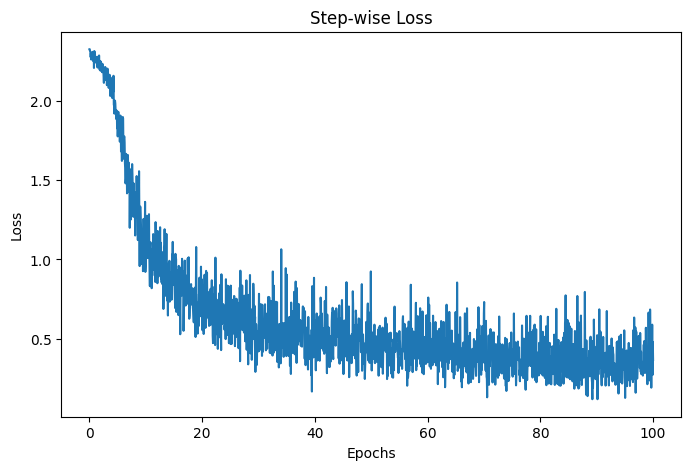

[2.3038813720703124, 0.193499658203125, 0.13334744720458985]


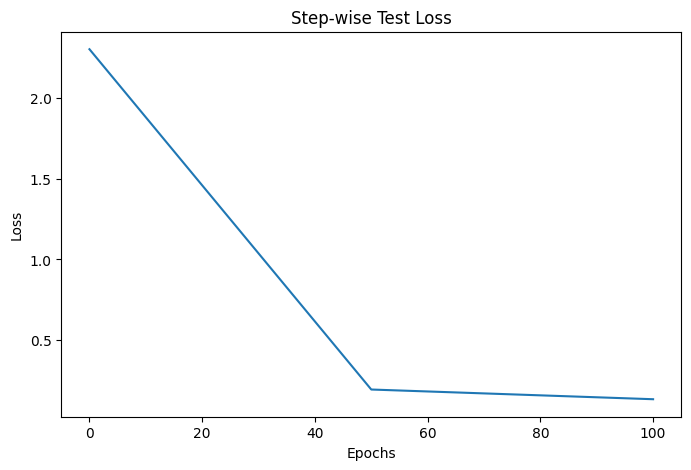

In [59]:
print(loss_values)
step = np.linspace(0, 100, len(loss_values))
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

print(test_loss_values)
step = np.linspace(0, 100, len(test_loss_values))
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(test_loss_values))
plt.title("Step-wise Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()